In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective, get_sparse_hessian

import matplotlib.pyplot as plt
%matplotlib inline

#import numpy as np

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']
#vp_base = json_dat['vp_base']

print(stan_dat.keys())
K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
#N = NObs / NG
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])

# An index set to make sure jacobians match the order expected by R.
prior_par_indices = copy.deepcopy(prior_par)
prior_par_indices.set_name('Prior Indices')
prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)

print(np.mean(y_vec))

dict_keys(['beta_prior_mean', 'N', 'beta_prior_info', 'y_group', 'mu_prior_info', 'mu_prior_mean', 'NG', 'y', 'K', 'x', 'tau_prior_beta', 'tau_prior_alpha'])
0.324


In [3]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = get_moment_jacobian(init_par_vec)

model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.0006081076979171484
	Grad time: 0.005675288301426917
	Hessian vector product time: 0.010804865299724043
	Prior hess time:  0.05826306343078613


In [4]:

glmm_par.set_free(np.random.random(glmm_par.free_size()))

sparse_model = logit_glmm.SparseModelObjective(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 4)

sparse_model.set_group_parameters(1)
sparse_model.get_group_elbo(1)

sparse_model.set_global_parameters()
sparse_model.get_global_elbo()



array([ 3.81398028])

In [5]:

objective = Objective(sparse_model.glmm_par, sparse_model.get_elbo)
full_elbo = objective.fun_vector(sparse_model.glmm_par.get_vector())

sparse_model.set_global_parameters()
sparse_elbo = sparse_model.get_global_elbo()
for g in range(NG):
    group_vec, group_inds = sparse_model.set_group_parameters(g)
    sparse_elbo += sparse_model.get_group_elbo_from_vec(group_vec, g)

print(sparse_elbo)
print(full_elbo)

[-738.99319975]
-738.993199751699


In [12]:
print('Gettin\' that ol\' Hessian:')

full_hess_time = time.time()
full_hess = objective.fun_vector_hessian(sparse_model.glmm_par.get_vector())
full_hess_time = time.time() - full_hess_time

print('Full Hessian time: ', full_hess_time)



Gettin' that ol' Hessian:
Full Hessian time:  1.977499008178711
Gettin' that ol' free Hessian:
okey dokey


In [7]:

from scipy.sparse import csr_matrix

get_group_hessian = autograd.hessian(sparse_model.get_group_elbo_from_vec)
get_global_hessian = autograd.hessian(sparse_model.get_global_elbo_from_vec)

sparse_hess_time = time.time()

print('Global hessian:')
sparse_global_hess = get_sparse_hessian(
    set_parameters_fun=sparse_model.set_global_parameters,
    get_group_hessian=get_global_hessian,
    group_range=range(1),
    full_hess_dim = sparse_model.glmm_par.vector_size(),    
    print_every=1)

print('Local hessian:')
sparse_group_hess = get_sparse_hessian(
    set_parameters_fun=sparse_model.set_group_parameters,
    get_group_hessian=get_group_hessian,
    group_range=range(NG),
    full_hess_dim = sparse_model.glmm_par.vector_size(),
    print_every=10)

sparse_hess_time = time.time() - sparse_hess_time



Global hessian:
Group 0 of 0
Done.
Local hessian:
Group 0 of 99
Group 10 of 99
Group 20 of 99
Group 30 of 99
Group 40 of 99
Group 50 of 99
Group 60 of 99
Group 70 of 99
Group 80 of 99
Group 90 of 99
Done.


In [8]:
sparse_hess = sparse_global_hess + sparse_group_hess
print('Max difference (should be zero):', np.max(np.abs(full_hess - sparse_hess.todense())))
print('Stdev (so you know it\'s not all zeros):', np.std(full_hess[:]))
print('\n')

print('Sparse Hessian time: ', sparse_hess_time)
print('Sparse Hessian time per group: ', sparse_hess_time  / float(NG))

print('Full Hessian time: ', full_hess_time)
print('Sparse Hessian time: ', sparse_hess_time)



Max difference (should be zero): 9.94759830064e-14
Stdev (so you know it's not all zeros): 1.45007827342


Sparse Hessian time:  8.49004054069519
Sparse Hessian time per group:  0.0849004054069519
Full Hessian time:  2.0263516902923584
Sparse Hessian time:  8.49004054069519


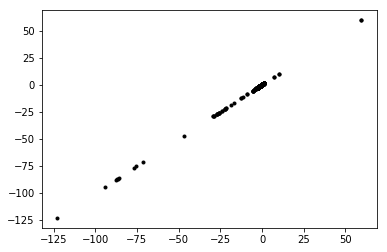

In [9]:
plt.plot(full_hess.flatten(), np.asarray(sparse_hess.todense()).flatten(), 'k.')

In [13]:
print('Gettin\' that ol\' free Hessian:')
full_free_hess = objective.fun_free_hessian(sparse_model.glmm_par.get_free())
print('okey dokey')

Gettin' that ol' free Hessian:
okey dokey


In [11]:
from VariationalBayes.Parameters import convert_vector_to_free_hessian

vector_grad = objective.fun_vector_grad(sparse_model.glmm_par.get_vector())
free_hess = convert_vector_to_free_hessian(
    sparse_model.glmm_par, sparse_model.glmm_par.get_free(),
    vector_grad,
    sparse_hess)



/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


1.20792265079e-13


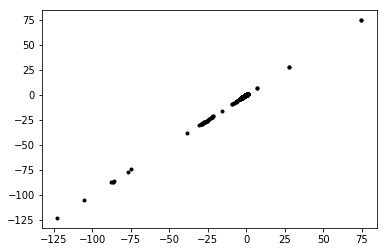

In [15]:
print(np.max(np.abs(full_free_hess.flatten() - np.asarray(free_hess.todense()).flatten())))
plt.plot(full_free_hess.flatten(), np.asarray(free_hess.todense()).flatten(), 'k.')